In [1]:
include("OQS_Tools_v1.jl")
using LinearAlgebra, Plots, PolyChaos
using .OQS_Tools_v1

function evolve_corrs(C0, H, dt, tmax, N)
    n = 2N + 1
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im * t * H)
        C = U * C0 * U'
        push!(Cs, C)
    end

    return Cs
end



evolve_corrs (generic function with 1 method)

In [2]:
N = 100
dt = 0.1
tmax = 100.0
Esys = 0.0
sys = N+1

D = 1.0
g = 0.1
beta = 10.0
mu = 0.0
sys_occ = 0.0

J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)

E1, h1 = chain_map(J1, N, D)
E2, h2 = chain_map(J2, N, D)
h = [reverse(h1); h2]

H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
C0 = prepare_correlations(N,sys,sys_occ)
Cs = evolve_corrs(C0, H, dt, tmax, N)


1001-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000007 - 2.25820106093668e-28im -7.184232666802026e-29 - 9.148516523884629e-18im … 0.0 + 0.0im 0.0 + 0.0im; -7.184232666802026e-29 + 9.148516523884629e-18im 1.0000000000000002 - 1.2010852429795847e-27im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.9999999999999999 + 3.799256291558082e-28im -1.423509640756523e-27 + 3.0398397112032787e-17im … 0.0 + 0.0im 0.0 + 0.0im; -1.423509640756523e-27 - 3.0398397112032787e-17im 1.0 - 1.91303525821982e-27im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.9999999999999998 + 3.020245829784349e-27im -1.17174340566844

┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/flux_g0.1B10.0mu0.0.gif
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/flux_g0.1B10.0mu0.0.gif")
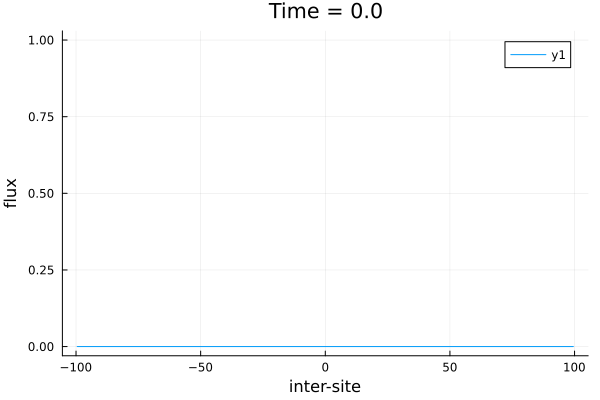

In [3]:
anim = @animate for (t,C) in enumerate(Cs)
    flux = imag.(diag(C, 1)) .* 2 .* h
    p = plot(-N+0.5:1:N-0.5, flux, title="Time = $(round(dt*(t-1),digits=1))", 
        xlabel="inter-site",ylabel="flux")
    end
gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/flux_g$(g)B$(beta)mu$(mu).gif", fps=20)


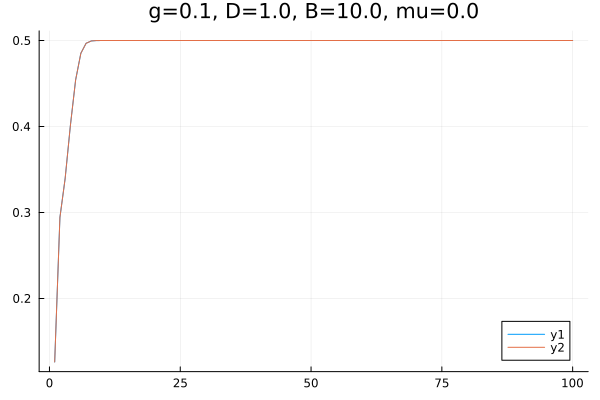

In [4]:
p = plot(h1, title="g=$g, D=$D, B=$beta, mu=$mu")
plot!(p, h2)
display(p)

In [5]:
function trace_distance(A, B, n, N) #1st matrix, 2nd matrix, chain sites included, chain sites
    Ma = A[N+1-n:N+1+n,N+1-n:N+1+n]
    Mb = B[N+1-n:N+1+n,N+1-n:N+1+n]
    D = 0.5 * tr(Ma .- Mb)
    return D
end

function block_entropy(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = Matrix(1.0I, 2n+1, 2n+1)
    S = -tr(Csub .* log(Csub) .+ (Id .- Csub) .* log(Id .- Csub))
    return S
end

block_entropy (generic function with 1 method)

GKS: Possible loss of precision in routine SET_WINDOW
┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/traceDist_g0.1B10.0mu0.0.gif
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/traceDist_g0.1B10.0mu0.0.gif")
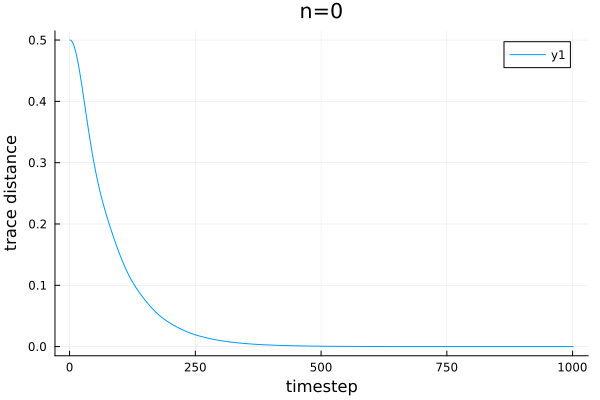

In [6]:
C0_full = prepare_correlations(N,sys,1.0)
C0_empty = prepare_correlations(N,sys,0.0)

Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
len = length(Cs_full)

anim = @animate for n in 0:N
    D = [trace_distance(Cs_full[t], Cs_empty[t], n, N) for t in 1:len]
    p = plot(real.(D),xlabel="timestep",ylabel="trace distance",title="n=$n")
end

gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/traceDist_g$(g)B$(beta)mu$(mu).gif", fps=5)


n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25


┌ Info: Saved animation to /Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/entropy_g0.1B10.0mu0.0.gif
└ @ Plots /Users/ben/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/entropy_g0.1B10.0mu0.0.gif")
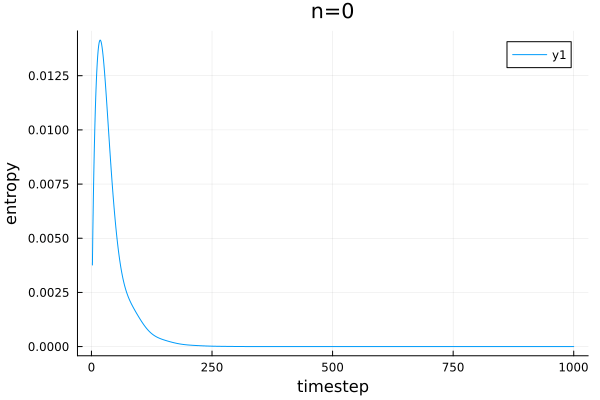

In [10]:
anim = @animate for n in 0:25
    S = [block_entropy(Cs_empty[t], n, N) for t in 1:len]
    S_b = S[2:end]
    S_i = S[1:end-1]
    S_r = S_b - S_i
    println("n=$n")
    p = plot(real.(S_r),xlabel="timestep",ylabel="entropy",title="n=$n")
end

gif(anim, "/Users/ben/AgeingManyBodyQuantumSys/Ben Code/figures/entropy_g$(g)B$(beta)mu$(mu).gif", fps=1)
